Minimum diffusion DDPM training / generation code for personal understaning.  
For simplicity  
- data : MNIST with image shape (28, 28, 1)  
- model : simple MLP with time embedding  
- no latent encoder such as VAE (i.e., non latent diffusion)  


In [1]:
from typing import Tuple, Any
import math

import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb

In [2]:
# Data Config
IMG_SHAPE = (1, 28, 28)

# Model Config
HIDDEN_DIM = 512
DROPOUT = 0.1

# Training Config
EPOCHS = 50
TRAIN_BATCH_SIZE = 64
LR = 3e-4
WEIGHT_DECAY = 1e-2

# Diffusion Config
STEPS = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data Pereparation

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.5, 0.5),
    ]),
    download=True,
)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.36MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.53MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([1, 28, 28]) 5


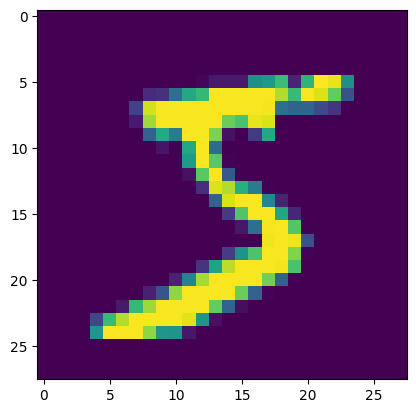

In [4]:
print(train_dataset[0][0].shape, train_dataset[0][1])
plt.imshow(train_dataset[0][0].squeeze().numpy())

## 2. Model

In [5]:
# Time Embedder (borrowed from micro diffusion)

class TimestepEmbedder(nn.Module):
    """Embeds scalar timesteps into vector representations.

    Args:
        hidden_size (int): Size of hidden dimension
        act_layer (Any): Activation layer constructor
        frequency_embedding_size (int, 512): Size of frequency embedding
    """
    def __init__(
        self,
        hidden_size: int,
        act_layer: Any = nn.SiLU,
        frequency_embedding_size: int = 512
    ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            act_layer(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t: torch.Tensor, dim: int, max_period: int = 10000) -> torch.Tensor:
        """Create sinusoidal timestep embeddings."""
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(
                start=0,
                end=half,
                dtype=torch.float32,
                device=t.device
            ) / half
        )
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size).to(self.dtype)
        return self.mlp(t_freq)

    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

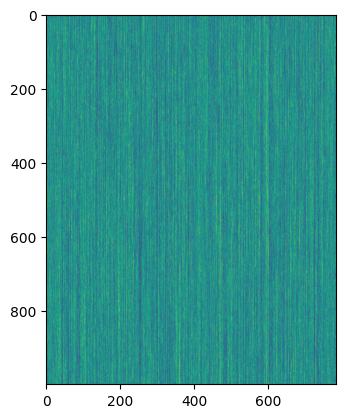

In [239]:
plt.imshow(TimestepEmbedder(hidden_size=28*28).eval()(torch.arange(0, 1000)).detach().numpy())

In [6]:
def modulate(x: torch.Tensor, shift: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Applies modulation to input tensor using shift and scale factors."""
    return x * (1 + scale) + shift

class ResMLPBlock(torch.nn.Module):

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        dropout: float = 0.0,
        use_layer_norm: bool = False,
    ):
        super().__init__()
        self._in_dim = in_dim
        self._out_dim = out_dim
        self._dropout = dropout
        self._in_proj = nn.Linear(in_dim, out_dim)
        self._norm = nn.LayerNorm(out_dim) if use_layer_norm else torch.nn.Identity()
        self._act = nn.GELU()
        self._dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        out = x + self._dropout(self._act(self._norm(self._in_proj(x))))
        return out

class DenoiseModel(torch.nn.Module):
    def __init__(
        self,
        img_shape: Tuple[int, int, int] = (1, 28, 28),  # (ch, h, w)
        hidden_dim: int = 256,
        dropout: float = 0.0,
        use_layer_norm: bool = False,
        n_layers: int = 2,
    ):
        super().__init__()
        self._in_dim = np.prod(img_shape)
        self._hidden_dim = hidden_dim
        self._dropout = dropout
        self._in_proj = nn.Linear(self._in_dim, hidden_dim)
        self._in_act = nn.GELU()
        denoise_mlp_layers = [
            ResMLPBlock(
                in_dim=hidden_dim,
                out_dim=hidden_dim,
                dropout=dropout,
                use_layer_norm=use_layer_norm,
            )
            for _ in range(n_layers)
        ]
        denoise_mlp_layers.append(nn.Linear(hidden_dim, self._in_dim))
        self._mlp_denoiser = nn.Sequential(*denoise_mlp_layers)
        self._timestep_embedder = TimestepEmbedder(hidden_size=hidden_dim)
        self._adaLN_modulation = nn.Sequential(
            nn.GELU(approximate="tanh"),
            nn.Linear(hidden_dim, 2 * hidden_dim, bias=True),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """Given noisy input image x_t and time t, predict the added noise (x_t - x_t-1).

        Args:
            x (torch.Tensor): input noisy image x_t with shape (bs, ch, h, w)
            t (torch.Tensor): time steps with shape (bs,)

        Returns:
            torch.Tensor: Predicted added noise image (x_t - x_t-1) with shape (bs, ch, h, w)
        """
        bs, ch, h , w = x.shape
        assert self._in_dim == ch * h * w
        x = x.flatten(1)  # (bs, ch, h, w) => (bs, ch x h x w)
        x_emb = self._in_act(self._in_proj(x))  # (bs, ch x h x w) => (bs, hidden_dim)
        t_emb = self._timestep_embedder(t)  # (bs,) => (bs, hidden_dim)
        shift, scale = self._adaLN_modulation(t_emb).chunk(2, dim=1)
        x_t_fused = modulate(x_emb, shift, scale)
        # x_t_fused = x_emb + t_emb
        # added_noise = self._mlp_denoiser(x_t_fused)
        added_noise = x - self._mlp_denoiser(x_t_fused)
        added_noise = added_noise.reshape(bs, ch, h, w)   # (bs, hidden_dim) => (bs, ch x h x w)
        return added_noise

In [35]:
_denoise_model = DenoiseModel(
    img_shape=IMG_SHAPE,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
).to(device).eval()

with torch.inference_mode():
    _out = _denoise_model(torch.randn(1, *IMG_SHAPE).to(device), torch.tensor([0.0]).to(device))
    print(_out.shape)

torch.Size([1, 1, 28, 28])


## 3. DDPM Scheduler Utils

In [11]:
def get_alpha_beta_sigma_scheduler(
    steps: int,
    # noise_beta = (0.5, 1.0),
    noise_beta = (0.0001, 0.02),
    device = device,
) -> Tuple[torch.Tensor, torch.Tensor]:
    b1, b2 = noise_beta
    beta_scheduler = [b1 + i*(b2-b1)/steps for i in range(steps)]
    alpha_scheduler = [1.0 - beta for beta in beta_scheduler]
    beta_scheduler = torch.tensor(beta_scheduler, device=device, dtype=torch.float32)
    alpha_scheduler = torch.tensor(alpha_scheduler, device=device, dtype=torch.float32)
    alpha_cumprod_scheduler = alpha_scheduler.cumprod(0)
    sigma_scheduler = (beta_scheduler * (1.0 - alpha_cumprod_scheduler.roll(1)) / (1.0 - alpha_cumprod_scheduler)).sqrt()
    sigma_scheduler[0] = 0.0
    return beta_scheduler, alpha_scheduler, alpha_cumprod_scheduler, sigma_scheduler

In [31]:
beta_scheduler, alpha_scheduler, alpha_cumprod_scheduler, sigma_scheduler = get_alpha_beta_sigma_scheduler(steps=STEPS, noise_beta=(0.0001, 0.02))

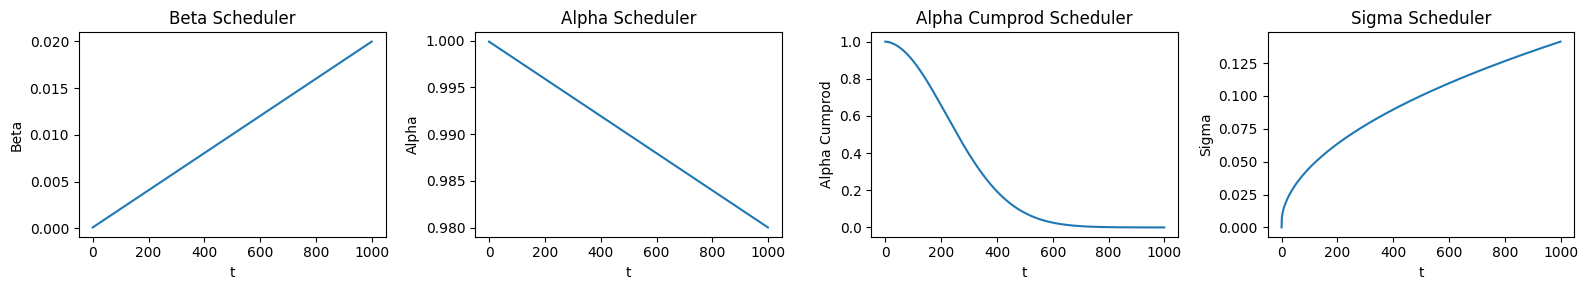

In [32]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(4*4, 3))

axes[0].plot(beta_scheduler.cpu().numpy())
axes[0].set_xlabel('t')
axes[0].set_ylabel('Beta')
axes[0].set_title('Beta Scheduler')

axes[1].plot(alpha_scheduler.cpu().numpy())
axes[1].set_xlabel('t')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha Scheduler')

axes[2].plot(alpha_cumprod_scheduler.cpu().numpy())
axes[2].set_xlabel('t')
axes[2].set_ylabel('Alpha Cumprod')
axes[2].set_title('Alpha Cumprod Scheduler')

axes[3].plot(sigma_scheduler.cpu().numpy())
axes[3].set_xlabel('t')
axes[3].set_ylabel('Sigma')
axes[3].set_title('Sigma Scheduler')

fig.tight_layout()

## 4. Denoise(generation) / Add Noise Utils

- Denoise (For Generation)

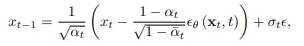

Following above equations, apply denoising process step by step to generate final image $x_0$ starting from pure noise $x_{t_{max}} \sim \mathcal{N}(0,\,1)$, where  
$\alpha_t=1-\beta_t$  
$\overline{\alpha}_{t} = \prod \alpha_t = \prod (1-\beta_t)$  
$ \sigma_{t}^2 = \frac{1.0 - \overline{\alpha}_{t-1}}{1.0 - \overline{\alpha}_{t}}\beta_t$  
$\epsilon_{\theta}(\boldsymbol{x}_{t}, t)$ : model output (predicted noise added to $x_t$)  
$\epsilon \sim \mathcal{N}(0,\,1)$


In [33]:
@torch.inference_mode()
def generate(
    denoise_model: nn.Module,
    img_shape: Tuple[int, int, int] = IMG_SHAPE,
    steps: int = STEPS,
    beta_scheduler: torch.Tensor = beta_scheduler,
    alpha_scheduler: torch.Tensor = alpha_scheduler,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
    sigma_scheduler: torch.Tensor = sigma_scheduler,
    n_generate: int = 1,
    debug: bool = False,
) -> torch.Tensor:
    denoise_model.eval()
    # create initial pure noise x_tmax
    bs = n_generate
    x_t = init_noise = torch.randn(bs, *img_shape)

    for t in reversed(range(1, steps)):
        # predict noise to denoise from x_t
        pred_noise = denoise_model(x_t, torch.tensor([t]).repeat((bs,)))
        if debug:
            print('pred', (pred_noise.min(), pred_noise.max()), (x_t.min(), x_t.max()))
        # apply denoise equation above
        x_prev_t = x_t - pred_noise * (1 - alpha_scheduler[t]) / ((1 - alpha_cumprod_scheduler[t]).sqrt())
        x_prev_t /= alpha_scheduler[t].sqrt()
        x_prev_t += sigma_scheduler[t] * torch.randn_like(x_prev_t)
        x_t = x_prev_t
        if debug:
            print(x_prev_t.max())

    x_0 = x_prev_t  # generated image x_0
    return x_0

In [36]:
gen_img = generate(_denoise_model, debug=False)
print(gen_img.shape)

torch.Size([1, 1, 28, 28])


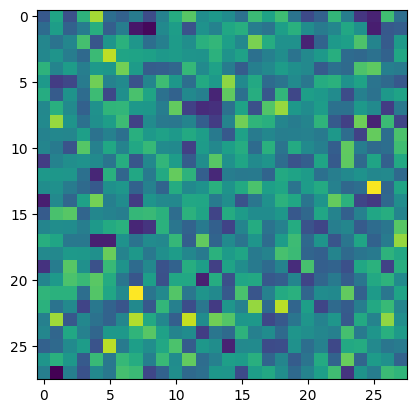

In [37]:
plt.imshow(gen_img[0].permute(1, 2, 0))

- Add Noise (For Training)

image.png

In [38]:
def add_noise(
    x_0: torch.Tensor,
    steps: int = STEPS,
    alpha_cumprod_scheduler: torch.Tensor = alpha_cumprod_scheduler,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Add noise corresponding to random time steps to ground-truth image x_0 to get x_t_rand

    Args:
        x (torch.Tensor): input ground-trueth image x_0 with shape (bs, ch, h, w)

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: noised added image x_t_rand, added noise, random timestepps correponsing to added noise
    """
    bs, ch, h, w = x_0.shape
    random_timesteps = torch.randint(0, steps, (bs,))
    alpha_prod = alpha_cumprod_scheduler[random_timesteps].reshape((bs, 1, 1, 1))

    noise = torch.randn_like(x_0)
    x_noisy = x_0 * alpha_prod.sqrt() + noise * (1 - alpha_prod).sqrt()
    return x_noisy, noise, random_timesteps

In [39]:
_x_noisy, _noise, _random_timesteps = add_noise(next(iter(train_dataloader))[0])
print(_x_noisy.shape, _noise.shape, _random_timesteps.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28]) torch.Size([64])


## 4. Run Training

In [40]:
model = DenoiseModel(
    img_shape=IMG_SHAPE,
    hidden_dim=1024,
    dropout=DROPOUT,
    use_layer_norm=True,
    n_layers=10,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [41]:
model

DenoiseModel(
  (_in_proj): Linear(in_features=784, out_features=1024, bias=True)
  (_in_act): GELU(approximate='none')
  (_mlp_denoiser): Sequential(
    (0): ResMLPBlock(
      (_in_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (_act): GELU(approximate='none')
      (_dropout): Dropout(p=0.1, inplace=False)
    )
    (1): ResMLPBlock(
      (_in_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (_act): GELU(approximate='none')
      (_dropout): Dropout(p=0.1, inplace=False)
    )
    (2): ResMLPBlock(
      (_in_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (_act): GELU(approximate='none')
      (_dropout): Dropout(p=0.1, inplace=False)
    )
    (3): ResMLPBlock(
      (_in_proj): Linear(in_features=1024, out_featur

epoch 0 : loss 0.1941867172718048


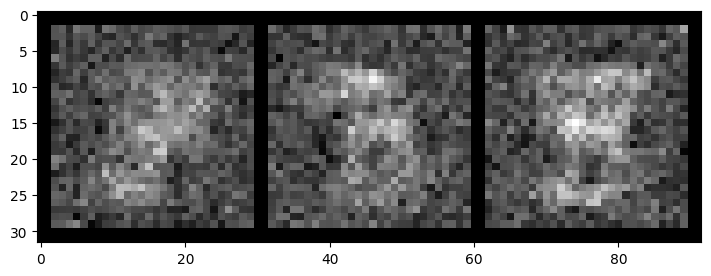

epoch 1 : loss 0.1434749960899353


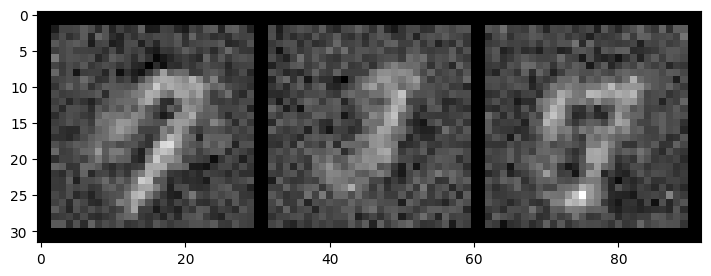

epoch 2 : loss 0.1345015913248062


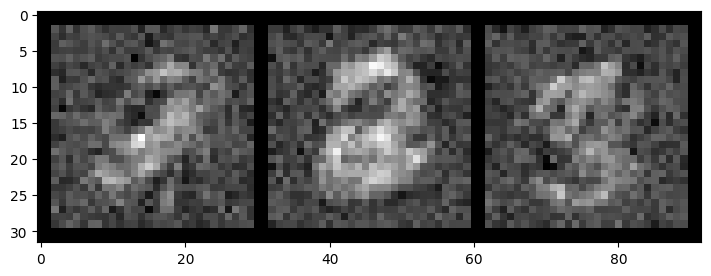

epoch 3 : loss 0.12216638773679733


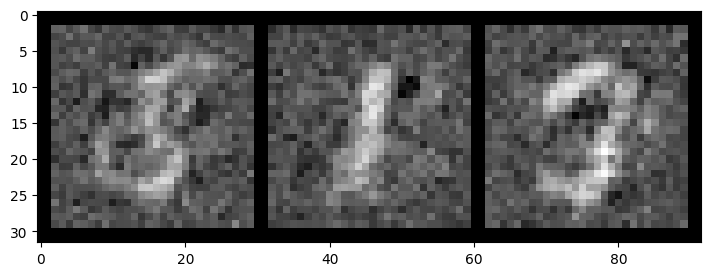

epoch 4 : loss 0.11337802559137344


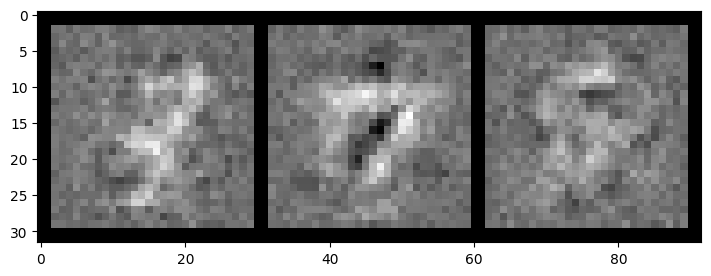

epoch 5 : loss 0.10967748612165451


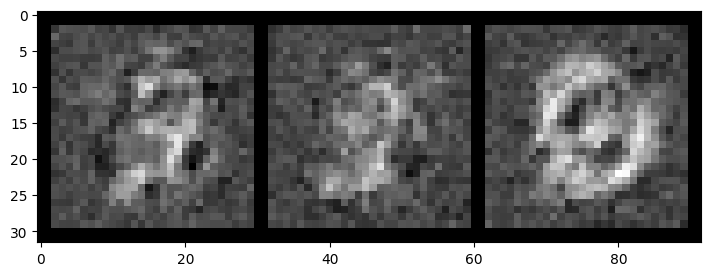

epoch 6 : loss 0.10266251862049103


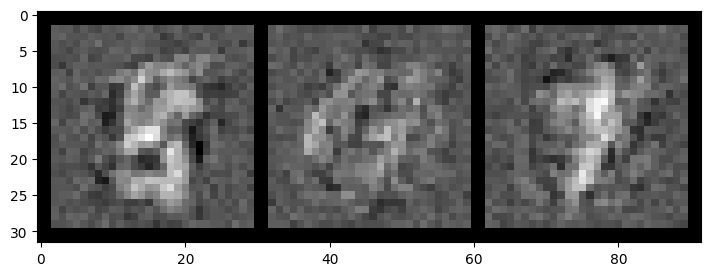

epoch 7 : loss 0.10042580217123032


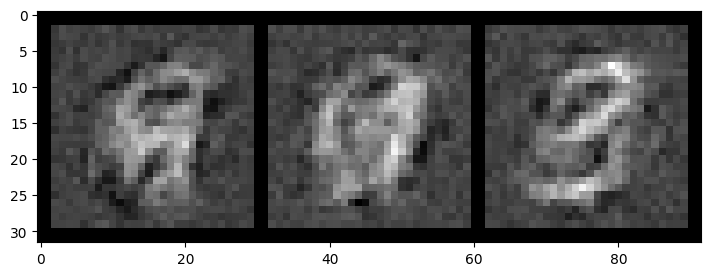

epoch 8 : loss 0.09636199474334717


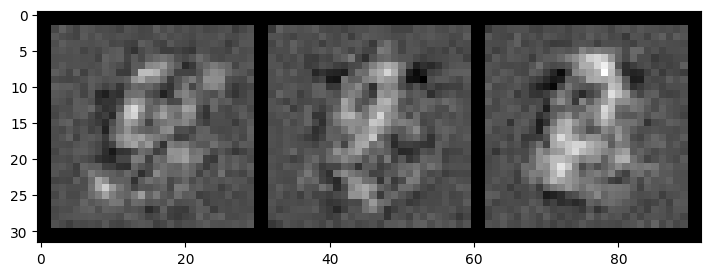

epoch 9 : loss 0.09431970864534378


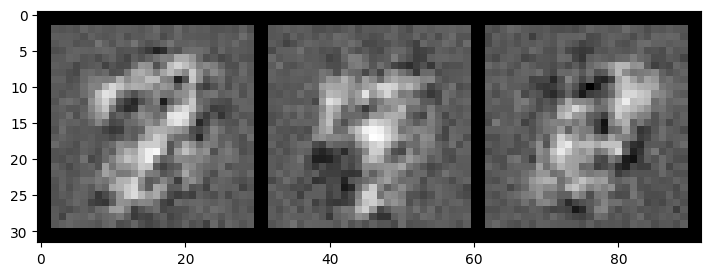

epoch 10 : loss 0.09364023804664612


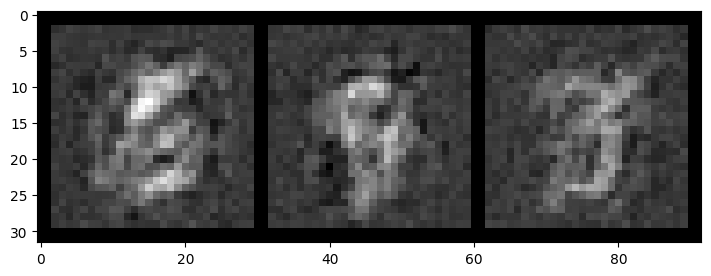

epoch 11 : loss 0.09378314018249512


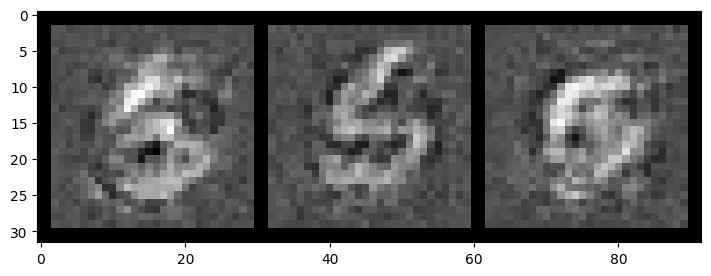

epoch 12 : loss 0.09034621715545654


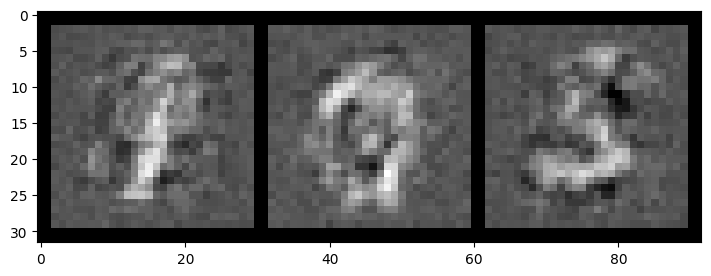

epoch 13 : loss 0.09226571768522263


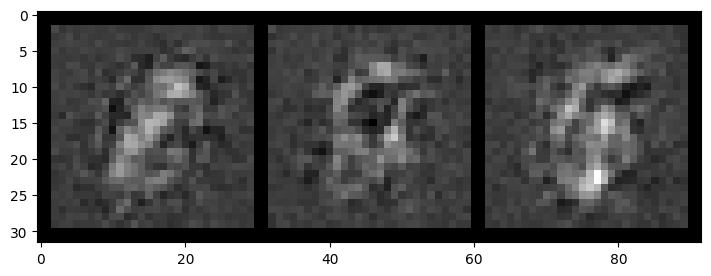

epoch 14 : loss 0.09029608964920044


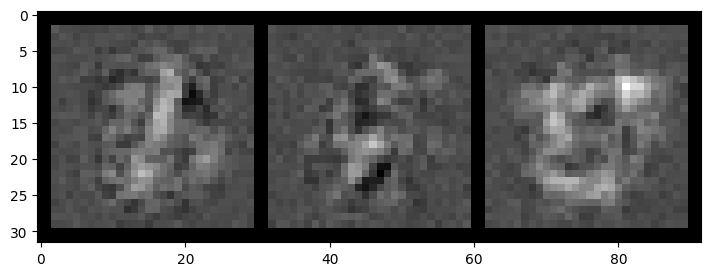

epoch 15 : loss 0.09099933505058289


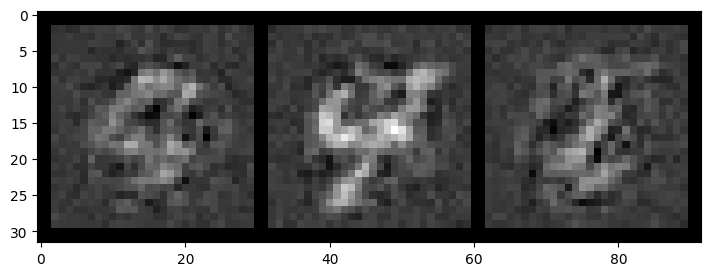

epoch 16 : loss 0.08914708346128464


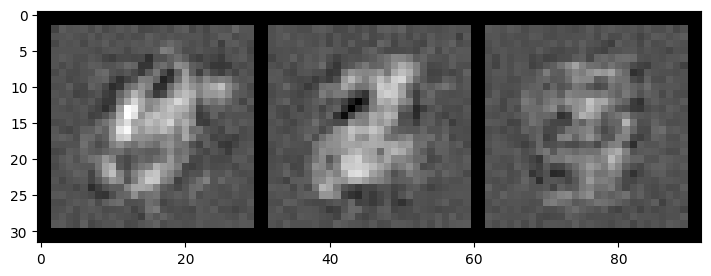

epoch 17 : loss 0.08875861018896103


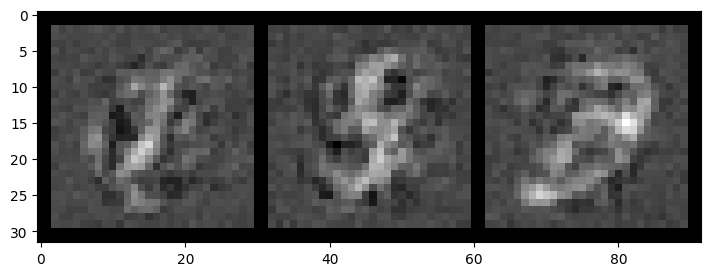

epoch 18 : loss 0.10267563164234161


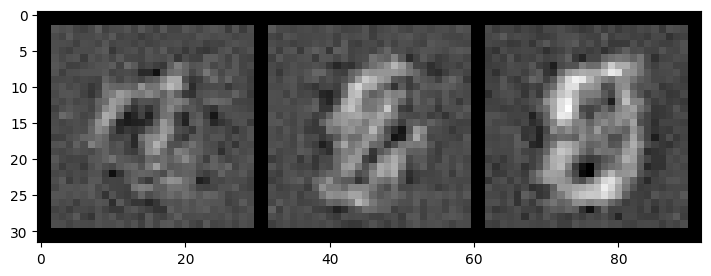

epoch 19 : loss 0.09014158695936203


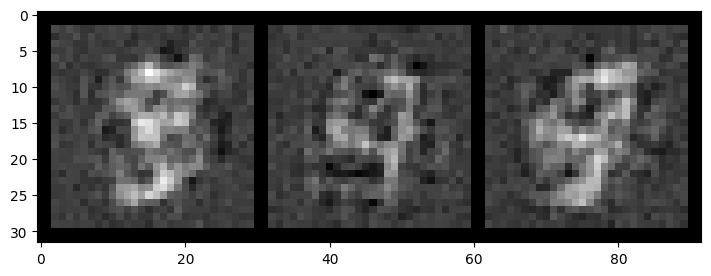

KeyboardInterrupt: 

In [42]:
loss_history = []

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    epoch_loss = 0.0
    for (batch_image, batch_class) in pb(train_dataloader):
        optimizer.zero_grad()
        batch_image = batch_image.to(device)
        x_noisy, noise, random_timesteps = add_noise(batch_image, steps=STEPS)  # (bs, ch, h, w), (bs, ch, h, w), (bs,)
        pred_noise = model(x_noisy, random_timesteps)  # (bs, ch, h, w)
        loss = torch.nn.functional.mse_loss(pred_noise.float(), noise.float())
        if torch.isnan(loss):
            print('loss is nan')
            break
        loss.backward()
        optimizer.step()
        epoch_loss += loss.cpu().detach()
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]}')

    # Ealuluation Phase
    model.eval()
    gen_img = generate(model, n_generate=3)
    gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())
    grid_image = torchvision.utils.make_grid(gen_img, nrow=3)
    plt.figure(figsize=(3*3, 3))
    plt.imshow(grid_image.permute(1, 2, 0))
    plt.show()

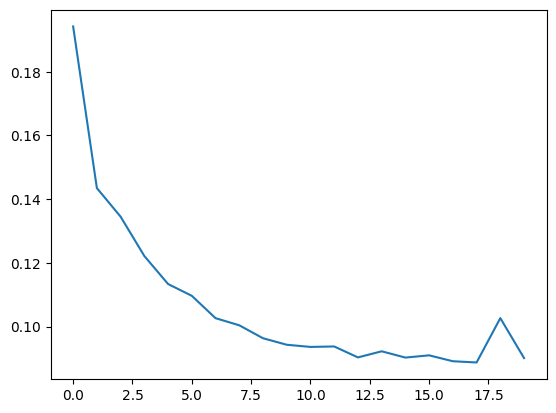

In [43]:
plt.plot(loss_history)

## 5. Generate Images with Trained Model

In [44]:
%%time
gen_img = generate(model, debug=False, n_generate=5*5)

CPU times: user 30.2 s, sys: 34.2 ms, total: 30.3 s
Wall time: 30.9 s


In [45]:
gen_img = (gen_img - gen_img.min()) / (gen_img.max() - gen_img.min())

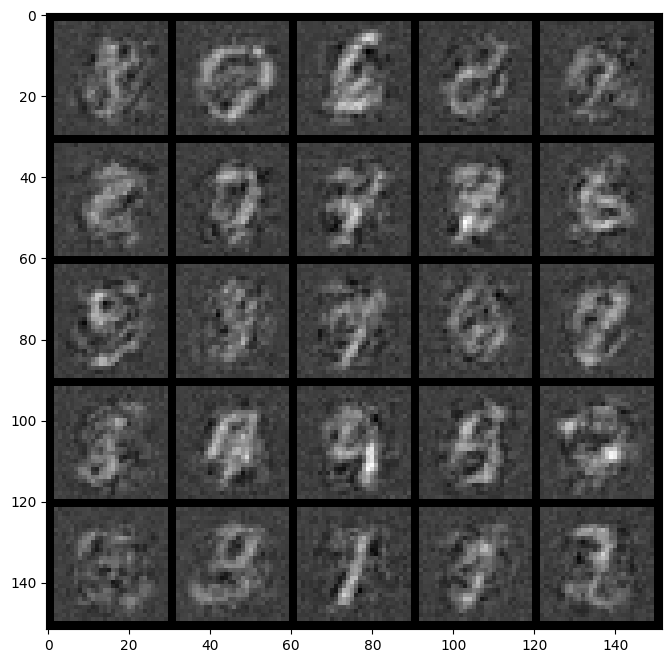

In [46]:
grid_image = torchvision.utils.make_grid(gen_img, nrow=5)
plt.figure(figsize=(8, 8))
plt.imshow(grid_image.permute(1, 2, 0))